In [4]:
import cv2

In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

C:\Users\MSI PC\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MSI PC\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\MSI PC\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


ImportError: Matplotlib requires numpy>=1.20; you have 1.18.5

In [6]:
data=pd.read_csv('icml_face_data.csv')

In [7]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [9]:
data = data.rename(columns = {' Usage':'Usage', ' pixels':'pixels'})

In [10]:
data.columns


Index(['emotion', 'Usage', 'pixels'], dtype='object')

<AxesSubplot:xlabel='emotion', ylabel='count'>

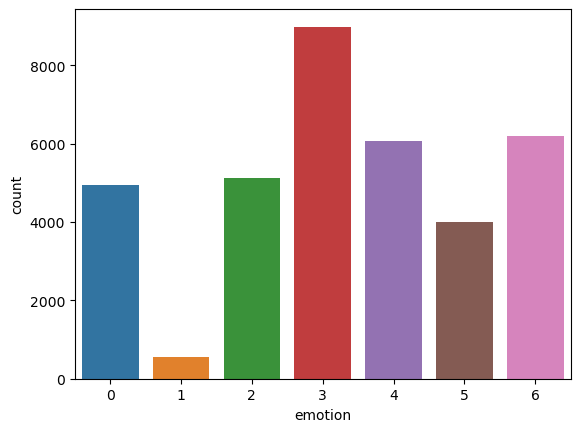

In [11]:
sns.countplot(x = data['emotion'])
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [1]:
def preprocess_data(data):
    # Convert the pixel values from integers to floats
    pixels = data['pixels'].tolist()
    pixels = [np.fromstring(pixel, dtype=int, sep=' ') for pixel in pixels]
    pixels = np.array(pixels, dtype=float)

    # Normalize the pixel values (between 0 and 1)
    pixels /= 255

    # Reshape the pixel values from a 1D array to a 3D array
    pixels = pixels.reshape(pixels.shape[0], 48, 48, 1)

    # Convert the emotion labels from integers to categorical values
    emotions = pd.get_dummies(data['emotion']).to_numpy()

    return pixels, emotions

In [2]:
train_data = data[data['Usage'] == 'Training']
validation_data = data[data['Usage'] == 'PublicTest']
test_data = data[data['Usage'] == 'PrivateTest']

X_train, y_train = preprocess_data(train_data)
X_validation, y_validation = preprocess_data(validation_data)
X_test, y_test = preprocess_data(test_data)

NameError: name 'data' is not defined

In [14]:
X_train.shape

(28709, 48, 48, 1)

In [15]:
y_train.shape

(28709, 7)

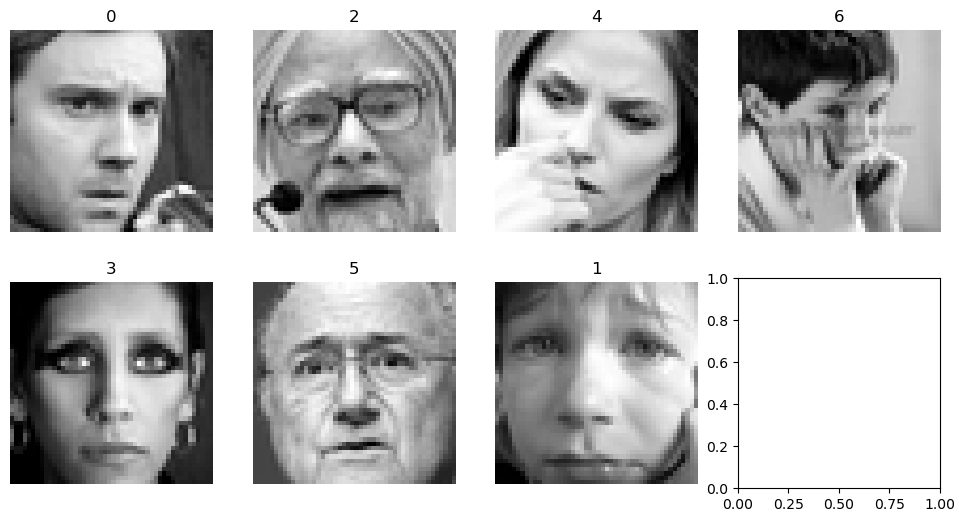

In [16]:
#example for each image class
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(7):
  ax[i // 4, i % 4].imshow(X_train[i].reshape(48, 48), cmap='gray')
  ax[i // 4, i % 4].set_title(data['emotion'].unique()[i])
  ax[i // 4, i % 4].axis('off')

plt.show()

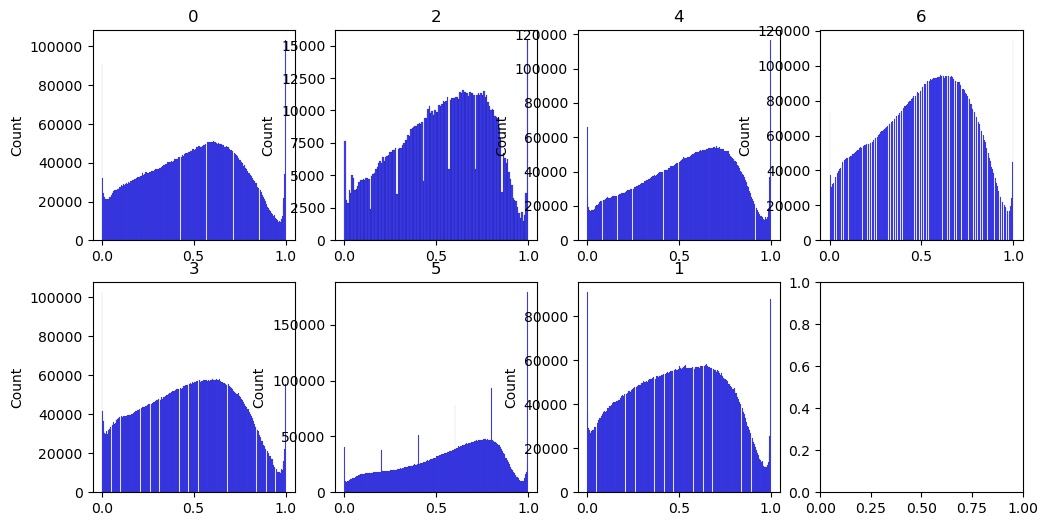

In [17]:
# Explore the distribution of the gray levels in each emotion class
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(7):
    sns.histplot(X_train[y_train[:, i] == 1].flatten(), ax=ax[i // 4, i % 4], color='blue')
    ax[i // 4, i % 4].set_title(data['emotion'].unique()[i])

plt.show()

In [18]:
y_train.shape


(28709, 7)

In [19]:
y_validation.shape

(3589, 7)

In [20]:
y_test.shape


(3589, 7)

In [21]:

import tensorflow as tf



In [22]:
with tf.device('/GPU:0'):
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

    # Freeze the layers of the VGG16 model except the last few layers
    for layer in vgg16.layers:
        layer.trainable = False
    for layer in vgg16.layers[-6:]:
        layer.trainable = True
    # Create a new model with the output of the VGG16 model as input
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    x = vgg16(x)
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    tf.config.optimizer.set_experimental_options({"passes": ["loop-fusion"]})
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=128)


    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)

Epoch 1/10
225/225 [==============================] - 549s 2s/step - loss: 1.6652 - accuracy: 0.3269 - val_loss: 1.4500 - val_accuracy: 0.4402
Epoch 2/10
225/225 [==============================] - 558s 2s/step - loss: 1.3753 - accuracy: 0.4695 - val_loss: 1.3124 - val_accuracy: 0.4926
Epoch 3/10
225/225 [==============================] - 586s 3s/step - loss: 1.2461 - accuracy: 0.5309 - val_loss: 1.3168 - val_accuracy: 0.4999
Epoch 4/10
225/225 [==============================] - 581s 3s/step - loss: 1.1671 - accuracy: 0.5615 - val_loss: 1.2190 - val_accuracy: 0.5358
Epoch 5/10
225/225 [==============================] - 556s 2s/step - loss: 1.0942 - accuracy: 0.5883 - val_loss: 1.1802 - val_accuracy: 0.5578
Epoch 6/10
225/225 [==============================] - 542s 2s/step - loss: 1.0262 - accuracy: 0.6130 - val_loss: 1.1835 - val_accuracy: 0.5667
Epoch 7/10
225/225 [==============================] - 525s 2s/step - loss: 0.9679 - accuracy: 0.6398 - val_loss: 1.2204 - val_accuracy: 0.5673

In [23]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231 

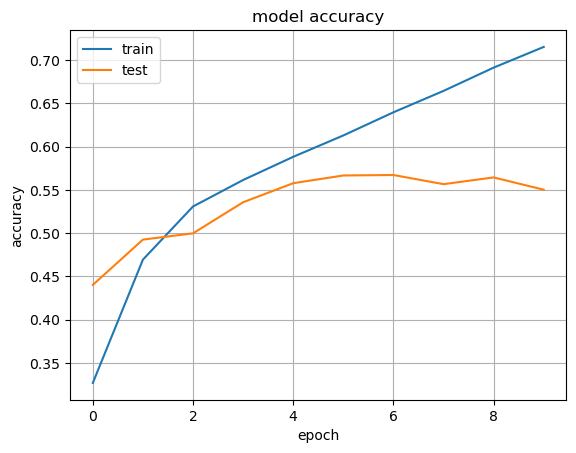

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

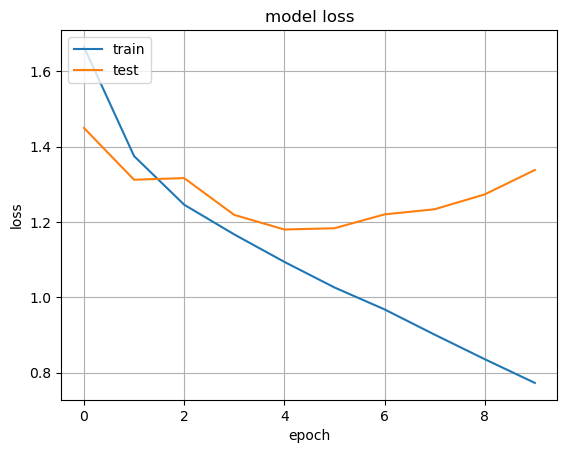

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [26]:
pred_test_labels = model.predict(X_test)

113/113 [==============================] - 19s 166ms/step


In [27]:
df_compare = pd.DataFrame()
df_compare['real'] = y_test.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [29]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [30]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

C:\Users\MSI PC\AppData\Local\Temp\ipykernel_9084\3116161387.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


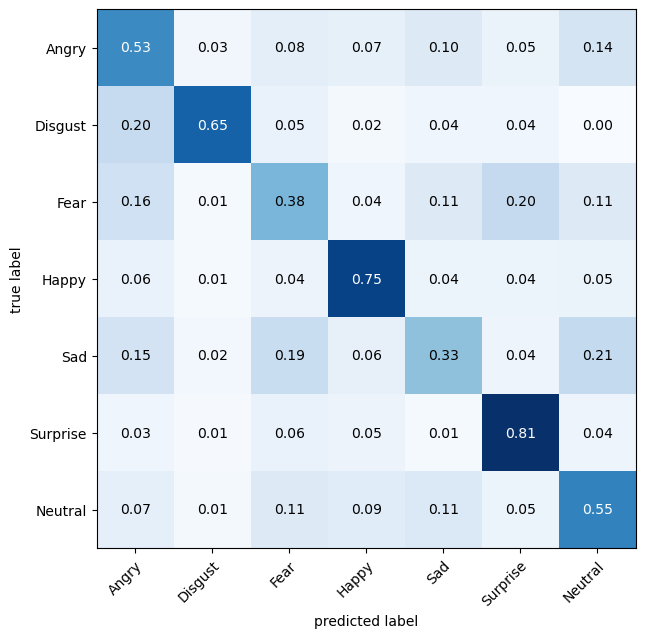

In [32]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(7, 7))
fig.show()